


# **Data pipeline**







***Downloading and extracting the CIfAR 10 dataset***

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xf /content/cifar-10-python.tar.gz 

--2022-11-10 04:28:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.8MB/s    in 13s     

2022-11-10 04:28:23 (12.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



***Importing the required libraries***

In [ ]:
import os
import pickle
import numpy as np
from PIL import Image
import tensorflow as tf
import random
import time
import scipy

**Unpickle the data**

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
# The path to data 
_data_root = "/content/Data/"

Reading the dataset 

In [ ]:
def load_data(data_dir):
   #load training data 
    for i in range(1, 6): 
        filename = data_dir+"data_batch_"+str(i) 
        dictionary = unpickle(filename) 
        x_data = dictionary[b'data']  
        y_data = np.array(dictionary[b"labels"])
        if i==1:   
            x_train = x_data  
            y_train= y_data  
        else:  
            x_train = np.concatenate((x_train, x_data), axis = 0)   
            y_train = np.concatenate((y_train, y_data), axis = 0) 
    #load testing data 
    filename = data_dir+"test_batch" 
    dictionary = unpickle(filename)
    data = dictionary[b"data"]
    x_test = data 
    y_test = np.array(dictionary[b"labels"]) 
    return x_train, y_train, x_test, y_test

**Splitting the data to training and validation dataset**

In [ ]:
def train_valid_split(x_train, y_train, split_index=48000):
    x_train_new = x_train[:split_index] 
    y_train_new = y_train[:split_index] 
    x_valid = x_train[split_index:] 
    y_valid = y_train[split_index:]
    return x_train_new, y_train_new, x_valid, y_valid

**parse our records in the data**:




Converting the image format from (n,depth * height * width) to first (n, depth ,height,width) and then to (n, width, height, depth) 

In [ ]:
def parse_record(records):
    n = len(records)
    depth_major = records.reshape((n,3, 32, 32))
    image = np.transpose(depth_major, [0,2, 3, 1])
    return image

In [ ]:
X_train, Y_train, X_test, Y_test = load_data(_data_root)

In [ ]:
X_train_new, Y_train_new, X_valid, Y_valid = train_valid_split(X_train, Y_train)

In [ ]:
images = parse_record(X_train_new)
X_valid = parse_record(X_valid)
X_test = parse_record(X_test)

**Scale Data**

In [ ]:
images = images/255
X_valid = X_valid/255
X_test = X_test/255

**Converting labels from integer representation to One hot encoding**

we will use "CategoricalCrossentropy()" loss function which requires its input to be one hot encoded

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(Y_train_new, 10)
y_val = np_utils.to_categorical(Y_valid, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

**Showing some data samples**

In [ ]:
from matplotlib import pyplot as plt

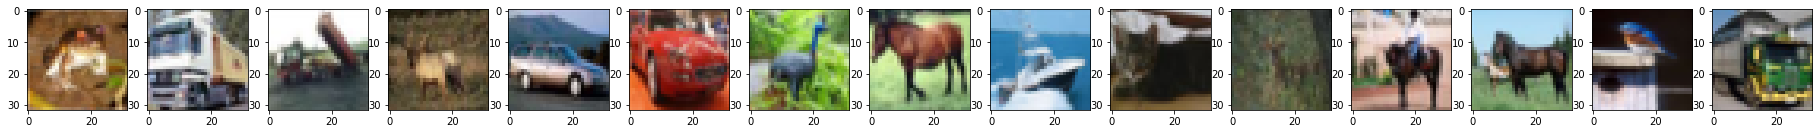

In [ ]:
fig, ax = plt.subplots(ncols=15, figsize=(32,32))
for i in range(15):
    ax[i].imshow(images[i])


#Build Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Using data augmentation to prevent the model from Overfitting**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

**Bulding the model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1,padding="same", activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, (3,3), 1,padding="same", activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), 1,padding="same", activation='relu'))
model.add(Conv2D(64, (3,3), 1,padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(516, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile("adam", loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                      

# Train

In [ ]:
logdir='/content/logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(datagen.flow(images,y_train), epochs=50, validation_data=datagen.flow(X_valid, y_val,
         batch_size=8),steps_per_epoch=len(images) / 32, 
                 callbacks=[tensorboard_callback])

# Plot Performance

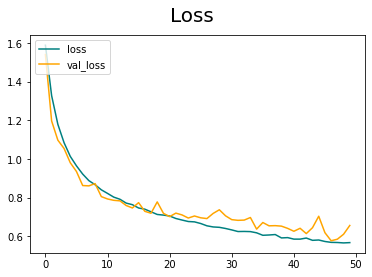

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

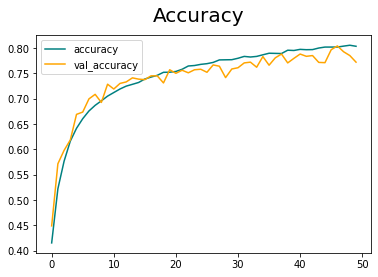

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Save the Model


In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

# Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
yhat = model.predict(X_test)
pre.update_state(Y_test, yhat)
re.update_state(Y_test, yhat)
acc.update_state(Y_test, yhat)

313/313 [==============================] - 37s 119ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=109980.0>

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8368715, shape=(), dtype=float32) tf.Tensor(0.7491362, shape=(), dtype=float32) tf.Tensor(0.96031094, shape=(), dtype=float32)


# Test

In [ ]:
img = X_test[600]

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
new_model = load_model('/content/models/imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(img, 0))